In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
import itertools
from tqdm.contrib.concurrent import process_map

np.random.seed(42)

/home/jk/projects/itmo/statistics/.venv/lib/pypy3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SAMPLE_SIZE = [10, 100, 1000, 10_000]
QUANTILES = [0.01, 0.05, 0.5]
DISTRIBUTIONS = {
    "NORMAL": lambda n: np.random.normal(0, 1, n),
    "UNIFORM": lambda n: np.random.uniform(0, 1, n),
}
PRECISION = 100
SIGMA = 0.05
EPS_ZERO = 0.005
X_SPACE = np.linspace(0, 1, PRECISION)
NUM_EXPERIMENTS = 10_000

In [3]:

def histogram_nbins(n):
    return math.floor(1 + 1.59 * math.log(n))

def gaussian_kernel(x, sigma): # N_0,1
    return (1 / np.sqrt(2 * np.pi) / sigma) * np.exp(-0.5 * x**2 / sigma**2)

def dup(arr):
    return np.array(list(map(lambda x: [x, x], arr))).flatten()

def make_cdf(sample, xs):
    sorted_sample = np.sort(sample)
    
    y = np.array([np.mean(sorted_sample <= r) for r in xs])

    return y

In [4]:
def make_kde(sample, xs, sigma):
    kde = np.zeros_like(xs)

    for r in sample:
        kde += gaussian_kernel((xs - r), sigma)
        
    kde /= len(sample)
    
    return kde

def make_hist(rs, bins):
    return np.histogram(rs, bins)

In [30]:
def sample_quantile(sample, q):
    assert q <= 1
    assert len(sample) > 0

    sorted_sample = np.sort(sample)

    i = len(sample) * q
    i = min(i, len(sample) - 1)
    i = max(i, 0)

    return (
        sorted_sample[int(i)]
        if i % 1 == 0
        else q * (sorted_sample[math.floor(i)] + sorted_sample[math.ceil(i)])
    )

def cdf_quantile(sample, cdf, q):
    i = np.searchsorted(cdf, q)
    i = min(i, len(cdf) - 1)
    i = max(i, 0)
    return sample[i]

def hist_quantile(hist, bins, q):
    cdf_hist = np.cumsum(hist) / np.sum(hist)
    i = np.searchsorted(cdf_hist, q)
    i = min(i, len(cdf_hist) - 1)
    i = max(i, 0)

    diff = q - cdf_hist[i] # diff = diff_width * hist[i]
    diff_width = diff / hist[i]
    quantile = bins[i] + diff_width
    print(bins[i])

    return quantile

def kde_quantile(phi, xs, q):
    cdf_kde = np.cumsum(phi) / len(xs)
    return cdf_quantile(xs, cdf_kde, q)

def ecdf_quantile(sample, ecdf, q):
    return cdf_quantile(sample, ecdf, q)

In [6]:
def draw_kde(sample, xs, qs):
    kde_sample = make_kde(sample, xs, SIGMA)
    #PDF
    plt.figure(figsize=(12, 8))
    plt.plot(xs, kde_sample, label='KDE', linewidth=2)
    plt.plot([0, 1], [1, 1], 'r--', label='генеральная плотность', linewidth=2)
    plt.title(f'n = {len(kde_sample)}')
    plt.xlabel('x')
    plt.ylabel('P(x)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # CDF
    plt.figure(figsize=(12, 8))
    plt.plot(xs, np.cumsum(kde_sample) / len(kde_sample), label="cdf(kde(x))", linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--', label='Генеральное распределение', linewidth=2)
    for qi in qs:
        kde_qi = kde_quantile(kde_sample, xs, qi)
        print(f"q_{qi} = {kde_qi}")
        plt.plot([kde_qi] * 2, [0, 1], "g-", label=f"Квантиль {qi}", linewidth=2)
    plt.title(f'cdf(kde(x)), n = {len(sample)}')
    plt.xlabel('x')
    plt.ylabel('cdf(kde(x))')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

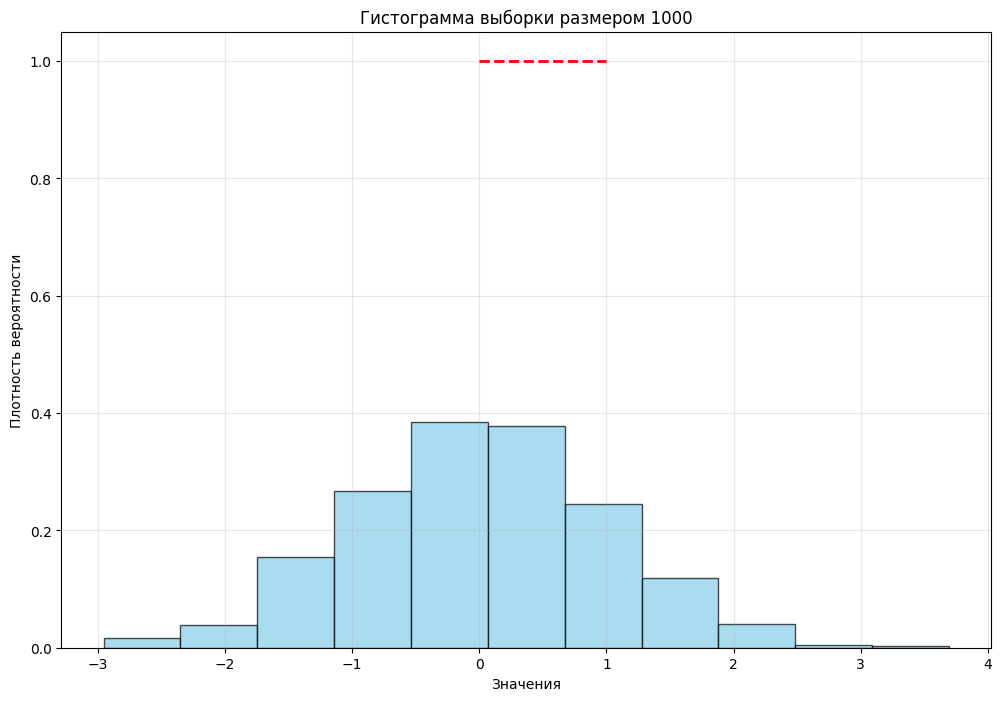

-2.9565538398886106
q_0.01 = -2.9565538398886106 (0.001)
-1.7472639941058825
q_0.05 = -1.7480831430420527 (0.033)
-0.5379741483231544
q_0.5 = -0.5380685689240128 (0.289)


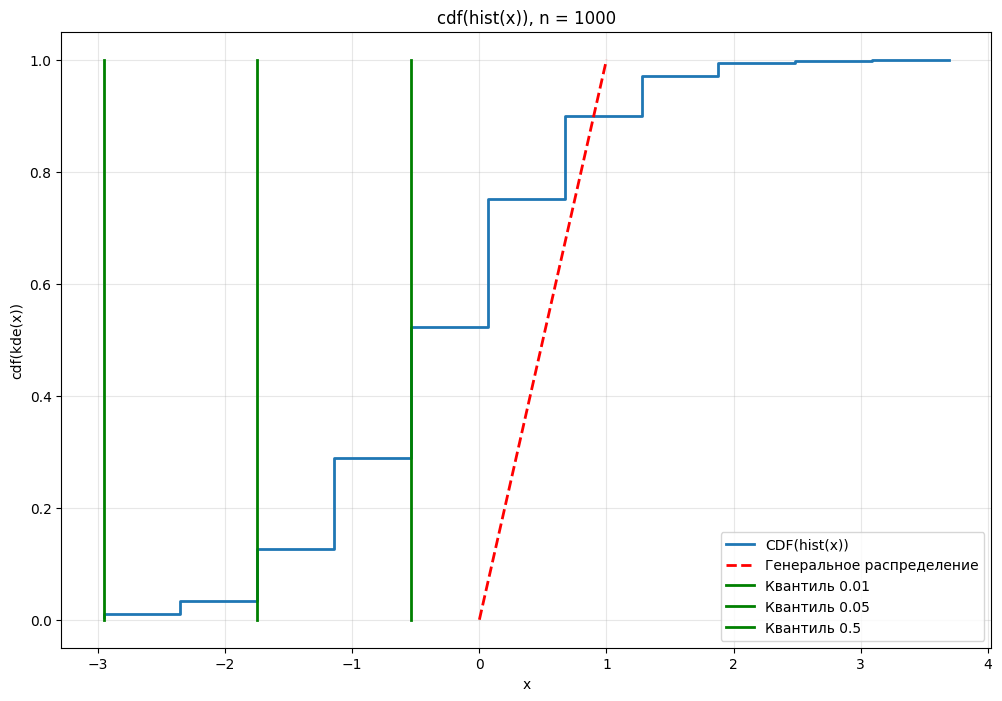

In [32]:
def draw_hist(sample, qs):
    nbins = histogram_nbins(len(sample))
    hist, bins = make_hist(sample, nbins)

    # hist
    plt.figure(figsize=(12, 8))
    plt.hist(sample, bins=bins, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    # plt.bar(bins[:-1] + (1 / nbins / 2), hist / (np.sum(hist) / nbins), width=1 / nbins, alpha=0.7, color='skyblue', edgecolor='black')
    plt.plot([0, 1], [1, 1], 'r--', label='генеральная плотность', linewidth=2)
    plt.title(f'Гистограмма выборки размером {len(sample)}')
    plt.xlabel('Значения')
    plt.ylabel('Плотность вероятности')
    plt.grid(True, alpha=0.3)
    plt.show()

    # CDF (hist)
    cdf_hist = np.insert(np.cumsum(hist) / np.sum(hist), 0, EPS_ZERO)
    plt.figure(figsize=(12, 8))
    plt.plot(np.insert(dup(bins)[:-1], 0, float("-inf")), dup(cdf_hist), label="CDF(hist(x))", linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--', label='Генеральное распределение', linewidth=2)
    for qi in qs:
        kde_qi = hist_quantile(hist, bins, qi)
        print(f"q_{qi} = {kde_qi} ({np.mean(sample <= kde_qi)})")
        plt.plot([kde_qi] * 2, [0, 1], "g-", label=f"Квантиль {qi}", linewidth=2)
    plt.plot()
    plt.title(f'cdf(hist(x)), n = {len(sample)}')
    plt.xlabel('x')
    plt.ylabel('cdf(kde(x))')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

draw_hist(DISTRIBUTIONS["NORMAL"](1000), QUANTILES)

In [8]:
def draw_ecdf(sample, xs, qs):
    # dist
    plt.figure(figsize=(12, 8))
    plt.plot(xs, sample, label='Выборочное распределение', linewidth=2)
    plt.plot([0, 1], [1, 1], 'r--', label='Генеральная плотность распределения', linewidth=2)
    plt.title(f'n = {len(sample)}')
    plt.xlabel('x')
    plt.ylabel('P(x)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # cdf
    cdf_sample = make_cdf(sample, xs)
    plt.figure(figsize=(12, 8))
    plt.plot(dup(xs), dup(cdf_sample), label="cdf(x)", linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--', label='Генеральное распределение', linewidth=2)
    for qi in qs:
        kde_qi = ecdf_quantile(cdf_sample, qi)
        print(f"q_{qi} = {kde_qi}")
        plt.plot([kde_qi] * 2, [0, 1], "g-", label=f"Квантиль {qi}", linewidth=2)
    plt.plot()
    plt.title(f'cdf(x), n = {len(sample)}')
    plt.xlabel('x')
    plt.ylabel('cdf(x))')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [18]:
def experiment(args):
    dist, n, e = args
    sample = DISTRIBUTIONS[dist](n)

    cdf_sample = make_cdf(sample, X_SPACE)
    kde_sample = make_kde(sample, X_SPACE, SIGMA)
    hist_sample, bins = make_hist(sample, histogram_nbins(len(sample)))

    qs = []
    for q in QUANTILES:
        ecdf_q = ecdf_quantile(X_SPACE, cdf_sample, q)
        kde_q = kde_quantile(kde_sample, X_SPACE, q),
        hist_q = hist_quantile(hist_sample, bins, q),
        qs.append((ecdf_q, kde_q, hist_q))

    result = (e, dist, n, *qs)
    return result

def draw(args):
    dist, n  = args
    sample = DISTRIBUTIONS[dist](n)
    draw_ecdf(sample, X_SPACE, QUANTILES)
    draw_kde(sample, X_SPACE, QUANTILES)
    draw_hist(sample, QUANTILES)


data = []
for args in itertools.product(DISTRIBUTIONS, SAMPLE_SIZE, range(2)):
    data.append(experiment(args))
# data = process_map(experiment, itertools.product(DISTRIBUTIONS, SAMPLE_SIZE, QUANTILES, range(NUM_EXPERIMENTS)))
# data = process_map(experiment, itertools.product(DISTRIBUTIONS, SAMPLE_SIZE, range(2)))
# data = list(map(draw, itertools.product(DISTRIBUTIONS, [SAMPLE_SIZE[-1]])))

In [10]:
df = pd.DataFrame(data, columns=["ex", "dist", "sample_size", "quantile_001", "quantile_005", "quantile_05" ])

In [22]:
df[df.dist == "NORMAL"].groupby("sample_size").var()

TypeError: agg function failed [how->var,dtype->object]